# Tutorial 3: Attention

**By Neuromatch Academy**

**Content creators:** Saaketh Medepalli, Aditya Singh, Saeed Salehi, Xaq Pitkow


---
# Tutorial Objectives

By the end of this tutorial, we aim to:


1. Learn how the brain and AI systems implemention attention

2. Understand how multiplicative interactions allow flexible gating of information

3. Demonstrate the inductive bias of the self-attention mechanism towards learning functions of sparse subsets of variables

A key microarchitectural operation in brains and machines is **attention**. The essence of this operation is multiplication. Unlike the vanilla neural network operation, a nonlinear function of a weighted sum of inputs $f(\sum_j w_{j}x_j)$, the attention operation allows responses to *multiply* inputs. This enable computations like modulating weights by other inputs.

&nbsp;

In brains, the theory of the Spotlight of Attention (Posner et al 1980) posited that gain modulation allowed brain computations to highlight or select certain information, prioritizing it for subsequent computation. In machines, the seminal book Parallel Distributed Processing (Rumelhart, Hinton, McClelland 1986) described Sigma-Pi networks that included both sums ($\Sigma$) and products ($\Pi$) as fundamental operations, and mentioned. The Transformer network introduced in (Vaswani et al 2017) used a specific architecture featuring layers of multiplication and normalization. Many machine learning systems since then have fruitfully applied this architecture to language, vision, and many more modalities. In this tutorial we will isolate the central properties and generalization benefits of multiplicative attention shared by all of these applications.

&nbsp;

Exercises include simple attentional modulation of inputs, coding the self-attention mechanism, demonstrating its inductive bias, and interpreting the consequences of attention.


&nbsp;

References:
- Posner MI, Snyder CR, Davidson BJ (1980). Attention and the detection of signals. *Journal of experimental psychology: General*. 109(2):160.

- Rumelhart DE, McClelland JL, PDP Research Group (1986). *Parallel Distributed Processing*. MIT press.

- Vaswani A, Shazeer N, Parmar N, Uszkoreit J, Jones L, Gomez AN, Kaiser Ł, Polosukhin I (2017). [Attention is all you need.](https://papers.nips.cc/paper_files/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html) *Advances in Neural Information Processing Systems*.

- Thomas Viehmann, [toroidal - a lightweight transformer library for PyTorch](https://github.com/MathInf/toroidal)

- Edelman et al. 2022, *Inductive biases and variable creation in self-attention mechanisms*

- Deep Graph Library Tutorials, [Transformer as a Graph Neural Network](https://docs.dgl.ai/en/0.8.x/tutorials/models/4_old_wines/7_transformer.html)

- Lilian Weng, [Attention? Attention!](https://lilianweng.github.io/posts/2018-06-24-attention/)


---
# Setup


In [1]:
# Imports
import os
import sys
import math
import torch
import random
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")
fig_w, fig_h = plt.rcParams['figure.figsize']

In [3]:
# @title Plotting functions
def plot_loss_accuracy(t_loss, t_acc, v_loss = None, v_acc = None):
    plt.figure(figsize=(15, 4))
    plt.suptitle("Training and Validation for the Transformer Model")
    plt.subplot(1, 2, 1)
    plt.plot(t_loss, label="Training loss", color="red")
    if v_loss is not None:
        # plt.plot(v_loss, label="Valididation loss", color="blue")
        plt.scatter(len(t_loss)-1, v_loss, label="Validation loss", color="blue", marker="*")
        # plt.text(len(t_loss)-1, v_loss, f"{v_loss:.3f}", va="bottom", ha="right")
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks([])
    plt.legend(loc="lower right")
    plt.subplot(1, 2, 2)
    plt.plot(t_acc, label="Training accuracy", color="red", linestyle="dotted")
    if v_acc is not None:
        # plt.plot(v_acc, label="Validation accuracy", color="blue", linestyle="--")
        plt.scatter(len(t_acc)-1, v_acc, label="Validation accuracy", color="blue", marker="*")
        # plt.text(len(t_acc)-1, v_acc, f"{v_acc:.3f}", va="bottom", ha="right")
    plt.xticks([])
    plt.ylim(0, 1)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.show()

def plot_samples(X_plot, y_plot, correct_ids, title=None):
    n_samples, seq_length = X_plot.shape
    fig, axs = plt.subplots(1, 2, figsize=(16, 2.5), sharey=True)
    rects = []
    for ri in correct_ids:
        rects.append(plt.Rectangle((ri-0.5, -0.5), 1, n_samples, edgecolor="red", alpha=1.0, fill=False, linewidth=2))
    axs[0].imshow(X_plot, cmap="binary")
    for rect in rects:
        axs[0].add_patch(rect)
    # axs[0].axis("off")
    axs[0].set_yticks([])
    axs[0].set_xticks([])
    axs[0].set_ylabel("Context")
    axs[0].set_xlabel("Samples")
    if title is not None:
        axs[0].set_title(title)
    axs[1].imshow(y_plot, cmap="binary")
    axs[1].add_patch(plt.Rectangle((-0.5, -0.5), 1, n_samples, edgecolor="black", alpha=1.0, fill=False, linewidth=2))
    axs[1].yaxis.set_label_position("right")
    axs[1].set_ylabel("Labels")
    axs[1].set_yticks([])
    axs[1].set_xticks([])
    plt.subplots_adjust(wspace=-1)
    plt.tight_layout()
    plt.show()

def plot_attention_weights(att_weights, correct_ids, context_length, labels):
    from matplotlib.lines import Line2D
    B = att_weights.size(0)
    aw_flatten = att_weights[:, -1, :-1].view(-1, context_length)
    x_axis = torch.arange(context_length).repeat(B, 1)
    y_axis = labels.view(-1, 1).repeat(1, context_length)
    aw_ravel = aw_flatten.ravel()
    x_ravel = x_axis.ravel()
    y_ravel = y_axis.ravel()

    fig, ax = plt.subplots(figsize=(9, 5))
    colors = ["red", "green"]
    labels_legened = ["True", "False"]
    ax.scatter(x_ravel, aw_ravel, alpha=0.1, c=[colors[int(y)] for y in y_ravel])
    rects = []
    for ri in correct_ids:
        rects.append(plt.Rectangle((ri-0.5, 1e-6), 1.0, 2.0, edgecolor="blue", alpha=1.0, fill=False, linewidth=2))
    for rect in rects:
        ax.add_patch(rect)
    plt.yscale("log")
    plt.ylim(1e-6, 2)
    plt.title("Attention weights for the whole batch")
    plt.xlabel("Boolean input index t")
    plt.ylabel("Attention weight")
    legend_elements = [Line2D([0], [0], linestyle='None', marker='o', color='green', label='True', markerfacecolor='g', markersize=7),
                       Line2D([0], [0], linestyle='None', marker='o', color='red', label='False', markerfacecolor='r', markersize=7)]
    ax.legend(handles=legend_elements, loc='upper right')
    plt.show()


def plot_compare(results_sat_d, results_sat_s, results_mlp_d, results_mlp_s,
                 B_t_sat_s, B_t_sat_d, B_t_mlp_s, B_t_mlp_d):
    from  matplotlib.colors import LinearSegmentedColormap
    cmap=LinearSegmentedColormap.from_list('rg',["w", "w", "r", "y", "g"], N=256)

    t_loss_sat_d, t_acc_sat_d, v_loss_sat_d, v_acc_sat_d, model_np_sat_d = results_sat_d
    t_loss_sat_s, t_acc_sat_s, v_loss_sat_s, v_acc_sat_s, model_np_sat_s = results_sat_s
    t_loss_mlp_d, t_acc_mlp_d, v_loss_mlp_d, v_acc_mlp_d, model_np_mlp_d = results_mlp_d
    t_loss_mlp_s, t_acc_mlp_s, v_loss_mlp_s, v_acc_mlp_s, model_np_mlp_s = results_mlp_s

    plt.figure(figsize=(8, 6))
    plt.subplot(2, 2, 1)
    plt.title("sparse", fontsize=16)
    plt.ylabel("Attention", fontsize=16)
    plt.barh(3, 0, color="blue")
    plt.barh(4, 0, color="green")
    plt.text(0.05, 3.5, f"# Parameters: {model_np_sat_s}")
    plt.text(0.05, 3.0, f"# samples: {B_t_sat_s}")
    plt.barh(2, t_acc_sat_s, color=cmap(t_acc_sat_s))
    plt.barh(1, v_acc_sat_s, color=cmap(v_acc_sat_s))
    plt.text(0.05, 2, f"# training acc: {t_acc_sat_s:.0%}")
    plt.text(0.05, 1, f"# validation acc: {v_acc_sat_s:.0%}")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 2, 2)
    plt.title("dense", fontsize=16)
    plt.barh(3, 0, color="blue")
    plt.barh(4, 0, color="green")
    plt.text(0.05, 3.5, f"# Parameters: {model_np_sat_d}")
    plt.text(0.05, 3.0, f"# samples: {B_t_sat_d}")
    plt.barh(2, t_acc_sat_d, color=cmap(t_acc_sat_d))
    plt.barh(1, v_acc_sat_d, color=cmap(v_acc_sat_d))
    plt.text(0.05, 2, f"# training acc: {t_acc_sat_d:.0%}")
    plt.text(0.05, 1, f"# validation acc: {v_acc_sat_d:.0%}")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 2, 3)
    plt.barh(3, 0, color="blue")
    plt.barh(4, 0, color="green")
    plt.text(0.05, 3.5, f"# Parameters: {model_np_mlp_s}")
    plt.text(0.05, 3.0, f"# samples: {B_t_mlp_s}")
    plt.barh(2, t_acc_mlp_s, color=cmap(t_acc_mlp_s))
    plt.barh(1, v_acc_mlp_s, color=cmap(v_acc_mlp_s))
    plt.text(0.05, 2, f"# training acc: {t_acc_mlp_s:.0%}")
    plt.text(0.05, 1, f"# validation acc: {v_acc_mlp_s:.0%}")
    plt.xticks([])
    plt.yticks([])
    plt.ylabel("MLP", fontsize=16)

    plt.subplot(2, 2, 4)
    plt.barh(3, 0, color="blue")
    plt.barh(4, 0, color="green")
    plt.text(0.05, 3.5, f"# Parameters: {model_np_mlp_d}")
    plt.text(0.05, 3.0, f"# samples: {B_t_mlp_d}")
    plt.barh(2, t_acc_mlp_d, color=cmap(t_acc_mlp_d))
    plt.barh(1, v_acc_mlp_d, color=cmap(v_acc_mlp_d))
    plt.text(0.05, 2, f"# training acc: {t_acc_mlp_d:.0%}")
    plt.text(0.05, 1, f"# validation acc: {v_acc_mlp_d:.0%}")
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")
    plt.show()

In [4]:
#@title Data retrieval
class s_Sparse_AND:  # 1-Dimensional AND
    def __init__(self, T: int, s: int):
        self.T = T # context length
        self.s = s # sparsity
        self.p = 0.5**(1.0/3.0)  # probability chosen for balanced data
        self.f_i = None

    def pick_an_f(self):
        self.f_i = sorted(random.sample(range(self.T), self.s))
        self.others = list(i for i in range(self.T) if i not in self.f_i)

    def generate(self, m: int, verbose: bool = False):
        if self.f_i is None:
            self.pick_an_f()
        max_try = 100
        i_try = 0
        while i_try < max_try:
            i_try += 1
            X, y = torch.zeros(m, self.T), torch.zeros(m, 1)
            X[torch.rand(m, self.T) < self.p] = 1
            y[X[:, self.f_i].sum(dim=1) == self.s] = 1
            if y.sum()/m < 0.4 or y.sum()/m > 0.6:
                verbose and print(f"Large imbalance in the training set {y.sum()/m}, retrying...")
                continue
            else:
                verbose and print(f"Data-label balance: {y.sum()/m}")
            bad_batch = False
            for i in self.f_i:
                for o in self.others:
                    if (X[:, i] == X[:, o]).all():
                        verbose and print(f"Found at least another compatible hypothesis {i} and {o}")
                        bad_batch = True
                        break
            if bad_batch:
                continue
            else:
                break
        else:
            verbose and print("Could not find a compatible hypothesis")
        return X.long(), y.float()


# From notebook
# Load an example image from the imagenet-sample-images repository
def load_image(path):
  """
  Load an image from a given path

  Args:
    path: String
      Path to the image

  Returns:
    img: PIL Image
      Image loaded from the path
  """
  img = Image.open(path)
  return img


In [5]:
# @title Helper functions

class BinaryMLP(torch.nn.Module):
    def __init__(self, in_dims, h_dims, out_dims, dropout=0.1):
        super().__init__()
        self.in_dims = in_dims
        self.h_dims = h_dims
        self.out_dims = out_dims

        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(in_dims, h_dims[0]))
        torch.nn.init.normal_(self.layers[-1].weight, std=0.02)
        torch.nn.init.zeros_(self.layers[-1].bias)
        self.layers.append(torch.nn.GELU())
        self.layers.append(torch.nn.Dropout(dropout))
        for i in range(len(h_dims) - 1):
            self.layers.append(torch.nn.Linear(h_dims[i], h_dims[i+1]))
            torch.nn.init.normal_(self.layers[-1].weight, std=0.02)
            torch.nn.init.zeros_(self.layers[-1].bias)
            self.layers.append(torch.nn.GELU())
            self.layers.append(torch.nn.Dropout(dropout))
        self.layers.append(torch.nn.Linear(h_dims[-1], out_dims))
        self.layers.append(torch.nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class BinarySAT(torch.nn.Module):
    """Binary Self-Attention Transformer
    The code is adopted from "https://github.com/MathInf/toroidal" by Thomas Viehmann
    """
    def __init__(self, T: int, d: int, n_heads: int, n: int):
        super().__init__()
        self.T = T  # context length
        self.E = T + 1  # effective length (including cls token)
        self.d = d  # embedding size
        self.n_heads = n_heads  # number of heads
        self.scale = (d // n_heads) ** -0.5  # scaling factor (1 / sqrt(d_k))
        self.n = n  # number of hidden units
        assert d % n_heads == 0, "embedding size must be divisible by number of heads"
        self.v = 2  # vocabulary size (binary input, 0 or 1)
        att_drop=0.1
        out_drop=0.1
        mlp_drop=0.1
        ln_eps=1e-6

        # embedding layers
        self.toke = torch.nn.Embedding(2, d)  # token embedding
        self.cls = torch.nn.Parameter(torch.randn(1, 1, d))  # "cls / class / global" learnable token
        self.pose = torch.nn.Parameter(torch.randn(1, T + 1, d))  # positional embedding
        self.norm1 = torch.nn.LayerNorm(d, eps=ln_eps)  # [https://arxiv.org/pdf/2002.04745.pdf]

        # self-attention layers
        self.qkv = torch.nn.Linear(d, 3 * d)  # query, key, value layers
        self.dropout_attn = torch.nn.Dropout(att_drop)
        self.proj = torch.nn.Linear(d, d)  # projection layer
        self.dropout_out = torch.nn.Dropout(out_drop)
        self.norm2 = torch.nn.LayerNorm(d, eps=ln_eps)

        # MLP layers
        self.mlp_l1 = torch.nn.Linear(d, n)
        self.mlp_l2 = torch.nn.Linear(n, d)
        self.dropout_mlp = torch.nn.Dropout(mlp_drop)
        self.norm3 = torch.nn.LayerNorm(d, eps=1e-6)

        # clasification layer
        self.head = torch.nn.Linear(d, 1)

        # initialize weights and biases (per description in the paper)
        torch.nn.init.normal_(self.toke.weight, std=0.02)
        torch.nn.init.normal_(self.pose, std=0.02)
        torch.nn.init.normal_(self.cls, std=0.02)
        torch.nn.init.ones_(self.norm1.weight)
        torch.nn.init.zeros_(self.norm1.bias)

        torch.nn.init.normal_(self.qkv.weight, std=0.02)
        torch.nn.init.zeros_(self.qkv.bias)
        torch.nn.init.normal_(self.proj.weight, std=0.02)
        torch.nn.init.zeros_(self.proj.bias)
        torch.nn.init.ones_(self.norm2.weight)
        torch.nn.init.zeros_(self.norm2.bias)

        torch.nn.init.normal_(self.mlp_l1.weight, std=0.02)
        torch.nn.init.zeros_(self.mlp_l1.bias)
        torch.nn.init.normal_(self.mlp_l2.weight, std=0.02)
        torch.nn.init.zeros_(self.mlp_l2.bias)
        torch.nn.init.ones_(self.norm3.weight)
        torch.nn.init.zeros_(self.norm3.bias)

        torch.nn.init.normal_(self.head.weight, std=0.02)
        torch.nn.init.zeros_(self.head.bias)

    def forward(self, x):
        # Embedding
        B = x.size(0)  # batch size
        x = self.toke(x)
        x = torch.cat([x, self.cls.expand(B, -1, -1)], dim=1)
        x = x + self.pose

        # Transformer Block
        norm_x = self.norm1(x)  # [https://arxiv.org/pdf/2002.04745.pdf]
        q, k, v = self.qkv(norm_x).view(B, self.E, 3, self.n_heads, -1).unbind(dim=2)
        # # (Scaled Dot-Product Attention)
        logits = torch.einsum("bthc,bshc->bhts", q, k)  # query key product
        logits *= self.scale  # normalize against staturation
        attn = torch.softmax(logits, dim=-1)
        attn = self.dropout_attn(attn)
        output = torch.einsum("bhts,bshc->bthc", attn, v)  # weighted attention
        # # concat and linear projection with residual connection
        output = output.reshape(B, self.E, self.d)  # recombine
        output = self.proj(output)  # linear layer projection
        output = self.dropout_out(output)
        x = self.norm2(x + output)  # normalization and residual connection

        # MLP with residual connection
        output = torch.relu(self.mlp_l1(x))  # nonlinear layer
        output = self.dropout_mlp(output)
        output = self.mlp_l2(output)  # linear layer
        x = self.norm3(x + output)  # normalization and residual connection

        # projection
        x = self.head(x[:, -1])
        x = torch.sigmoid(x)  # binary classification task
        return x


def bin_acc(y_hat, y):
    """
    Compute the binary accuracy
    """
    y_ = y_hat.round()
    TP_TN = (y_ == y).float().sum().item()
    FP_FN = (y_ != y).float().sum().item()
    assert TP_TN + FP_FN == y.numel(), f"{TP_TN + FP_FN} != {y.numel()}"
    return TP_TN / y.numel()


def get_n_parameters(model: torch.nn.Module):
    """
    Get the number of learnable parameters in a model
    """
    i = 0
    for par in model.parameters():
        i += par.numel()
    return i


def save_model(model):
    torch.save(model.state_dict(), 'model_states.pt')


def load_model(model):
    model_states = torch.load('model_states.pt')
    model.load_state_dict(model_states)

def evaluator(model, criterion, X_v, y_v, device="cpu"):
    model.to(device)
    model.eval()
    X_v, y_v = X_v.to(device), y_v.to(device)
    with torch.no_grad():
        y_hat = model(X_v)
        loss = criterion(y_hat.squeeze(), y_v.squeeze())
        acc = bin_acc(y_hat, y_v)
    return loss.item(), acc


def trainer(model, optimizer, criterion, n_epochs, X_t, y_t, device="cpu", verbose=False):
    train_loss, train_acc = [], []
    model.to(device)
    model.train()
    X_t, y_t = X_t.to(device), y_t.to(device)
    for i in range(n_epochs):
        optimizer.zero_grad(set_to_none=True)
        y_hat = model(X_t)
        loss_t = criterion(y_hat.squeeze(), y_t.squeeze())
        loss_t.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        if (i + 1) % 10 == 0 or i == 0:
            train_loss.append(loss_t.item())
            train_acc.append(bin_acc(y_hat, y_t))
    model.eval()
    return train_loss, train_acc


def scaled_dot_product_attention_solution(Q, K, V):
    """ Scaled dot product attention
    Args:
        Q: queries (B, H, d, n)
        K: keys (B, H, d, n)
        V: values (B, H, d, n)
    Returns:
        Attention tensor (B, H, d, n), Scores (B, H, d, d)
    Notes:
        (B, H, d, n): batch size, H: number of heads, d: key-query dim, n: embedding dim
    """

    assert K.shape == Q.shape and K.shape == V.shape, "Queries, Keys and Values must have the same shape"
    B, H, d, n = K.shape  # batch_size, num_heads, key-query dim, embedding dim
    scale = math.sqrt(d)
    Q_mm_K = torch.einsum("bhdn,bhen->bhde", Q, K)  # dot-product reducing the n dimension
    S = Q_mm_K / scale  # score or scaled dot product
    S_sm = torch.softmax(S, dim=-1)  # softmax
    A = torch.einsum("bhde,bhen->bhdn", S_sm, V)  # Attention
    return A, S


def make_train(model, T, s, B_t, B_v, n_epochs, device="cpu", kind="MLP", results=True):
    etta = 1e-3
    data_gen = s_Sparse_AND(T, s)
    X_train, y_train = data_gen.generate(B_t, verbose=False)
    X_valid, y_valid = data_gen.generate(B_v, verbose=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=etta)
    criterion = torch.nn.BCELoss()
    model_np = get_n_parameters(model)  # number of learnable parameters
    results and print(f"Number of model's learnable parameters: {model_np}")
    if kind == "MLP":
        t_loss, t_acc = trainer(model, optimizer, criterion, n_epochs, X_train.float(), y_train, device=device, verbose=False)
        if results:
            v_loss, v_acc = evaluator(model, criterion, X_valid.float(), y_valid, device=device)
    else:
        t_loss, t_acc = trainer(model, optimizer, criterion, n_epochs, X_train, y_train, device=device, verbose=False)
        if results:
            v_loss, v_acc = evaluator(model, criterion, X_valid, y_valid, device=device)
    results and print(f"Training loss: {t_loss[-1]:.3f}, accuracy: {t_acc[-1]:.3f}")
    results and print(f"Validation loss: {v_loss:.3f}, accuracy: {v_acc:.3f}")
    if results:
        return t_loss[-1], t_acc[-1], v_loss, v_acc, model_np
    else:
        return data_gen


def weighted_attention(self, x):
    """This function computes the weighted attention as a method for the BinarySAT class

    Args:
        x (Tensor): An array of shape (B:batch_size, T:context length) containing the input data

    Returns:
        Tensor: weighted attention of shape (B, E, E) where E = T + 1
    """
    assert self.n_heads == 1, "This function is only implemented for a single head!"
    # Embedding
    B = x.size(0)  # batch size
    x = self.toke(x)  # token embedding
    x = torch.cat([x, self.cls.expand(B, -1, -1)], dim=1)  # concatenate cls token
    x = x + self.pose  # positional embedding
    norm_x = self.norm1(x)  # normalization

    # Scaled Dot-Product Attention (partially implemented)
    q, k, v = self.qkv(norm_x).view(B, self.E, 3, self.d).unbind(dim=2)
    # q, k, v all have shape (B, E, h, d) where h is the number of heads (1 in this case)
    W_qk = q @ k.transpose(-2, -1)
    W_qk = W_qk * self.scale
    W_qk = torch.softmax(W_qk, dim=-1)
    return W_qk


def results_dict(results_sat_d, results_sat_s, results_mlp_d, results_mlp_s):
    from collections import OrderedDict
    t_loss_sat_d, t_acc_sat_d, v_loss_sat_d, v_acc_sat_d, model_np_sat_d = results_sat_d
    t_loss_sat_s, t_acc_sat_s, v_loss_sat_s, v_acc_sat_s, model_np_sat_s = results_sat_s
    t_loss_mlp_d, t_acc_mlp_d, v_loss_mlp_d, v_acc_mlp_d, model_np_mlp_d = results_mlp_d
    t_loss_mlp_s, t_acc_mlp_s, v_loss_mlp_s, v_acc_mlp_s, model_np_mlp_s = results_mlp_s
    output = OrderedDict()
    # output["Training Loss SAT dense"] = t_loss_sat_d
    # output["Training Accuracy SAT dense"] = t_acc_sat_d
    output["Validation Loss SAT dense"] = round(v_loss_sat_d, 3)
    output["Validation Accuracy SAT dense"] = v_acc_sat_d
    output["Number of Parameters SAT dense"] = model_np_sat_d
    # output["Training Loss SAT sparse"] = t_loss_sat_s
    # output["Training Accuracy SAT sparse"] = t_acc_sat_s
    output["Validation Loss SAT sparse"] = round(v_loss_sat_s, 3)
    output["Validation Accuracy SAT sparse"] = v_acc_sat_s
    output["Number of Parameters SAT sparse"] = model_np_sat_s
    # output["Training Loss MLP dense"] = t_loss_mlp_d
    # output["Training Accuracy MLP dense"] = t_acc_mlp_d
    output["Validation Loss MLP dense"] = round(v_loss_mlp_d, 3)
    output["Validation Accuracy MLP dense"] = v_acc_mlp_d
    output["Number of Parameters MLP dense"] = model_np_mlp_d
    # output["Training Loss MLP sparse"] = t_loss_mlp_s
    # output["Training Accuracy MLP sparse"] = t_acc_mlp_s
    output["Validation Loss MLP sparse"] = round(v_loss_mlp_s, 3)
    output["Validation Accuracy MLP sparse"] = v_acc_mlp_s
    output["Number of Parameters MLP sparse"] = model_np_mlp_s
    return output



In [6]:
# @title Set random seed

import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Handles variability by controlling sources of randomness
  through set seed values

  Args:
    seed: Integer
      Set the seed value to given integer.
      If no seed, set seed value to random integer in the range 2^32
    seed_torch: Bool
      Seeds the random number generator for all devices to
      offer some guarantees on reproducibility

  Returns:
    Nothing
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [7]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [8]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()
print(DEVICE)

Random seed 2021 has been set.
cpu


---
# Section 1. Intro to multiplication

In this exercise we will show how signals can be used to selectively gate inputs. This is the essence of attention.



## Exercise 1

We'll implement simple dot product attention for input $\mathbf{x}$ and scalar output $y$ given by a weighted combination of the inputs,
$$y = \mathbf{w}\cdot\mathbf{x}$$
for weights $\mathbf{w}$. Unlike usual readouts, however, attention adjusts the weights based on other signals $\mathbf{z}$. Here we will use just a two dimensional attentional gain, $z_1$ and $z_2$, each with a corresponding key vector $\mathbf{q}$ that determines what is attended:

$$\mathbf{w}(z_1,z_2) = \text{softmax}(z_1 \mathbf{q}_1 + z_2 \mathbf{q}_2)$$

You should code up this function to return the attentional weights and output.

<div>
<img src="https://raw.githubusercontent.com/ssnio/nma_neuroai_d4_t4/main/static/Fig_0_ref2.png"/>
<figcaption>Figure from Inductive Biases and Variable Creation in Self-Attention Mechanisms</figcaption>
</div>

**Just include first panel above**

In [9]:
def gained_dot_product_attention(x: torch.Tensor,  # input vector
                                 q_1: torch.Tensor,  # query vector 1
                                 q_2: torch.Tensor,  # query vector 2
                                 z_1: float,  # key gain 1
                                 z_2: float,  # key gain 2
                                 ):
    """This function computes the gained dot product attention
    Args:
        x (Tensor): input vector
        q_1 (Tensor): query vector 1
        q_2 (Tensor): query vector 2
        z_1 (float): query gain 1
        z_2 (float): query gain 2
    Returns:
        w (Tensor): attention weights
        y (float): gained dot product attention
    """
    #################################################
    ## TODO Implement the `gained_dot_product_attention`
    # Fill remove the following line of code one you have completed the exercise:
    raise NotImplementedError("Student exercise: complete calculation of gained dot product attention.)
    #################################################
    w = ...
    y = ...
    return w, y

SyntaxError: unterminated string literal (detected at line 21) (451756952.py, line 21)

In [10]:
# to_remove solution
def gained_dot_product_attention(x: torch.Tensor,  # input vector
                                 q_1: torch.Tensor,  # query vector 1
                                 q_2: torch.Tensor,  # query vector 2
                                 z_1: float,  # query gain 1
                                 z_2: float,  # query gain 2
                                 ):
    """This function computes the gained dot product attention
    Args:
        x (Tensor): input vector
        q_1 (Tensor): query vector 1
        q_2 (Tensor): query vector 2
        z_1 (float): query gain 1
        z_2 (float): query gain 2
    Returns:
        w (Tensor): attention weights
        y (float): gained dot product attention
    """
    w = torch.softmax(z_1 * q_1 + z_2 * q_2, dim=0)
    y = torch.dot(w, x)
    return w, y

Now we plot the input weights. Manipulate the sliders to control the two attention gains $z_k$, which we've pre-assigned to two specific sigmoidal pattern vectors $\mathbf{q}_k$. (Feel free to change those functions and see how the sliders change what they attend.) Observe how these sliders change which part of the input is amplified and attenuated.

y: 0.3223479092121124


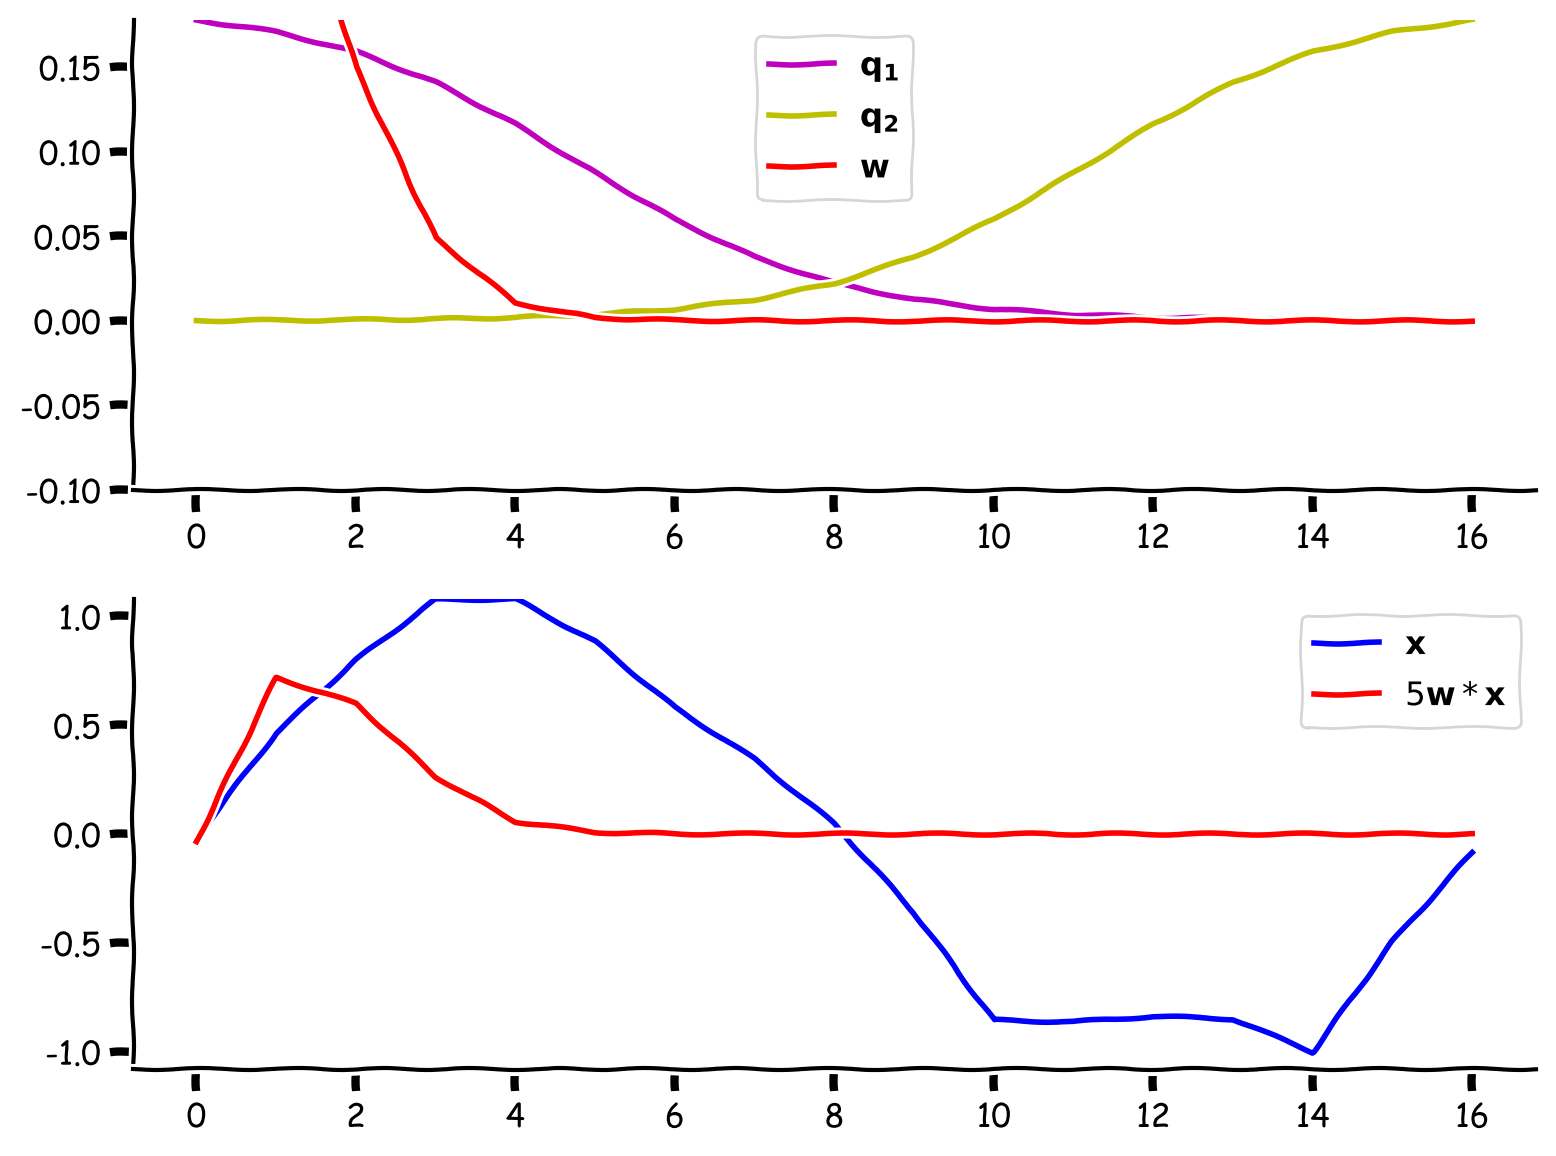

In [11]:
#@title { run: "auto" }
gain_1 = 61.8 # @param {type:"slider", min:0.1, max:100.0, step:0.1}
gain_2 = 0.1 # @param {type:"slider", min:0.1, max:100.0, step:0.1}
T = 17  # context length
# pre-defined signals
x = torch.sin(torch.linspace(0, 2*3.1415, T)) + 0.1 * torch.randn(T)
q_1 = 1.0 - torch.sigmoid(torch.linspace(-3, 7, T))
q_1 = q_1 / q_1.sum()
q_2 = torch.sigmoid(torch.linspace(-7, 3, T))
q_2 = q_2 / q_2.sum()

w, y = gained_dot_product_attention(x, q_1, q_2, gain_1, gain_2)

print(f"y: {y}")
with plt.xkcd():
    plt.figure(figsize=(8, 6))
    plt.subplot(2, 1, 1)
    plt.plot(q_1, label="$\mathbf{q_1}$", c="m")
    plt.plot(q_2, label="$\mathbf{q_2}$", c="y")
    plt.plot(w, label="$\mathbf{w}$", c="r")
    plt.ylim(-0.1, max(q_1.max(),q_2.max()))
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(x, label="$\mathbf{x}$", c="blue")
    plt.plot(5*x*w, label="$5\mathbf{w}*\mathbf{x}$", c="red")
    plt.ylim(-x.abs().max(), x.abs().max())
    plt.legend()
    plt.show()

The provided plot illustrates the impact of the gain factor on the attention weights for different input dimensions. The key observations and interpretations are as follows:

1. Sparsity and Selectivity:
   - The softmax includes both an exponentiation that exaggerates large values, and a normalization which ensures that the weights sum to 1. Thus, other weights decrease as the biggest weights increase.
   - This increased selectivity can focus on the most relevant features.
   
2. Gain Factor Influence:
   - For small gains, the attention weights are evenly distributed across the input dimensions.
   - As the gain factor increases, the attention weights become sparser: more concentrated and peaked.



# Section 2. Self-attention: math

Where do these gain factors come from?

In dot product attention, the weights were $\mathbf{w}=\text{softmax}(\mathbf{z}\cdot Q)$, a function of an external $\mathbf{z}$ and fixed matrix $Q$. (Above we used a 2-dimensional $\mathbf{z}$.)

In the *self-attention* mechanism used in Transformers, the attentional weights are instead functions of the same input $\mathbf{x}$ that is later modulated by these weights.

A very simple version would simply set $\mathbf{z}=\mathbf{x}$, so
$$\mathbf{w}=\text{softmax}(\mathbf{x}\cdot Q)$$

However, to provide more flexibility, we allow $Q$ to *also* depend on the input: $Q=W_q\mathbf{x}$. For even more flexibility, we select only specific aspects of the input to serve as gain modulation,
$$\mathbf{z}=W_k\mathbf{x}$$
so
$$\mathbf{w}=\text{softmax}(W_k \mathbf{x}\,\mathbf{x}^\top W_q)$$
Notice that the weights are themselves products of the input!

One final specialization is to allow multiple outputs, each being different projections of the weighted inputs: $y=\mathbf{w}\cdot W_v\mathbf{x}$. This use of multiple features is known as *multi-head* attention.

This is commonly described as a query-key-value framework. These various learnable projections of the input are given names:
$$
Q=W_q\mathbf{x}\ \ \ \ \text{query}\\
K=W_k\mathbf{x}\ \ \ \ \ \ \text{key}\\
V=W_v\mathbf{x}\ \ \ \ \text{value}
$$

The self-attention mechanism is then usually written as:

$$\mathbf{y}=\text{softmax}\,(\frac{QK^\top}{\sqrt{d}})V$$

where we get a big weight on inputs with a strong match between Query and Key, and that weight is applied to a particular set of Values. (For different dimensions $d$ of attended features, there's also a scaling by $\sqrt{d}$ in the softmax for convenience.)

&nbsp;

Putting all this together, the self-attention is then
$$
\mathbf{y}=\text{softmax}(\tfrac{1}{\sqrt{d}}W_q\mathbf{x}\mathbf{x}^\top W_k^\top)W_v\mathbf{x}
$$
This equation shows that **the attention mechanism in transformers is a composition of multiplication, sparsification, normalization, and another multiplication** --- all special microarchitecture operations!

|![alt](https://thegradient.pub/content/images/2020/09/attention-block.jpg) |![alt](https://thegradient.pub/content/images/2020/09/gnn-block.jpg)|
|-|-|

**Revision Note: update notation in figure, use only left panel**


### Exercise 2. Implement self-attention

In this exercise, you will implement the Attention operation from the transformer architecture, and test it against pre-written code.

&nbsp;

Assume that you are given the queries $Q$, keys $K$, and values $V$, each as projections of the inputs $W\mathbf{x}$.

These objects will have multiple features (heads) for each element. Denoting $B$ as the batch size, $H$ as the number of heads, $n$ as the embedding dimension, and $d$ as the dimensionality of the queries, keys, and values (for simplicity, we assume they have the same dimensionality), the objects we need to combine are

$$\text{Query} \ Q\in \mathcal{R}^{B \times H \times d \times n}\\
\text{Key} \ K\in \mathcal{R}^{B \times H \times d \times n}\\
\text{Value} \ V\in \mathcal{R}^{B \times H \times d \times n}
$$
The input to the softmax, $Q K^T/\sqrt{d}$, is sometimes called the attention Score,
$$
\text{Score}\ S\in \mathcal{R}^{B \times H \times d \times d}\\
\text{Attention}\ \mathbf{y}\in \mathcal{R}^{B \times H \times d \times n}
$$

**NOTES:**
$K$, $Q$, $V$ are multi-dimensional tensors. Since `torch.matmul`'s matrix multiplication does not support tensors, we can either use Einstein-Sum `einsum` or Batch-MatMul `bmm` for the MatMul operation. It is very important to keep in mind the notation and that we are first performing the dot-product (reduction) on the embedding dimension! The softmax is also applied along the context ($d$) dimension.



**Revision note: explain embedding dimension $n$**

In [12]:
def scaled_dot_product_attention(Q, K, V):
    """ Scaled dot product attention
    Args:
        Q: queries (B, H, d, n)
        K: keys (B, H, d, n)
        V: values (B, H, d, n)
    Returns:
        Attention tensor (B, H, d, n), Scores (B, H, d, d)
    Notes:
        (B, H, d, n): batch size, H: number of heads, d: key-query dim, n: embedding dim
    """

    assert K.shape == Q.shape and K.shape == V.shape, "Queries, Keys and Values must have the same shape"
    B, H, d, n = K.shape  # batch_size, num_heads, key-query dim, embedding dim
    scale = math.sqrt(d)

    #################################################
    # # TODO Scaled dot product attention
    # # You should choose between torch.bmm or torch.einsum
    # # Remove or comment out the lines you don't need
    # Fill remove the following line of code one you have completed the exercise:
    raise NotImplementedError("Student exercise: implement full version of scaled dot product attention.")
    #################################################
    # # START using torch.bmm #######################
    Q_ = Q.view(B * H, d, n) # necessary only if using torch.bmm
    K_ = K.view(B * H, d, n) # necessary only if using torch.bmm
    V_ = V.view(B * H, d, n) # necessary only if using torch.bmm
    Q_mm_K = ...  # dot-product reducing the n dimension
    S = ...  # score or scaled dot product
    S_sm = ...  # softmax
    A = ...  # Attention
    S = S.view(B, H, d, d) # necessary only if using torch.bmm
    A = A.view(B, H, d, n) # necessary only if using torch.bmm
    # # END using torch.bmm #########################
    # # START using torch.einsum ####################
    Q_mm_K = ...  # dot-product reducing the n dimension
    S = ...  # score or scaled dot product
    S_sm = ...  # softmax
    A = ...  # Attention
    # # END using torch.einsum ######################

    assert S.shape == (B, H, d, d), "Score tensor does not have the correct shape"
    assert A.shape == (B, H, d, n), "Attention tensor does not have the correct shape"
    return A, S  # Attention, Score


In [13]:
# to_remove solution
def scaled_dot_product_attention(Q, K, V):
    """ Scaled dot product attention
    Args:
        Q: queries (B, H, d, n)
        K: keys (B, H, d, n)
        V: values (B, H, d, n)
    Returns:
        Attention tensor (B, H, d, n), Scores (B, H, d, d)
    Notes:
        (B, H, d, n): batch size, H: number of heads, d: key-query dim, n: embedding dim
    """

    assert K.shape == Q.shape and K.shape == V.shape, "Queries, Keys and Values must have the same shape"
    B, H, d, n = K.shape  # batch_size, num_heads, key-query dim, embedding dim
    scale = math.sqrt(d)

    # # START using torch.bmm #######################
    Q_ = Q.view(B * H, d, n) # necessary only if using torch.bmm
    K_ = K.view(B * H, d, n) # necessary only if using torch.bmm
    V_ = V.view(B * H, d, n) # necessary only if using torch.bmm
    Q_mm_K = torch.bmm(Q_, K_.transpose(1, 2))  # dot-product reducing the n dimension
    S = Q_mm_K / scale  # score or scaled dot product
    S_sm = torch.softmax(S, dim=2)  # softmax
    A = torch.bmm(S_sm, V_)  # Attention
    S = S.view(B, H, d, d) # necessary only if using torch.bmm
    A = A.view(B, H, d, n) # necessary only if using torch.bmm
    # # END using torch.bmm #########################
    # # START using torch.einsum ####################
    Q_mm_K = torch.einsum("bhdn,bhen->bhde", Q, K)  # dot-product reducing the n dimension
    S = Q_mm_K / scale  # score or scaled dot product
    S_sm = torch.softmax(S, dim=-1)  # softmax
    A = torch.einsum("bhde,bhen->bhdn", S_sm, V)  # Attention
    # # END using torch.einsum ######################

    assert S.shape == (B, H, d, d), "Score tensor does not have the correct shape"
    assert A.shape == (B, H, d, n), "Attention tensor does not have the correct shape"
    return A, S  # Attention, Score


Here is a function to test whether your function matches the correct output for self-attention.

In [14]:
# Testing the function scaled_dot_product
batch_size = 7
n_heads = 4
key_query_value_dim = 3
embed_dim = 5
tensor_shape = (batch_size, n_heads, key_query_value_dim, embed_dim)
queries, keys, values = torch.rand(tensor_shape), torch.rand(tensor_shape), torch.rand(tensor_shape)
your_attention, your_score = scaled_dot_product_attention(queries, keys, values)
our_attention, our_score = scaled_dot_product_attention_solution(queries, keys, values)
assert (your_attention == our_attention).all(), "The two implementations should produce the same result"
assert (your_score == our_score).all(), "The two implementations should produce the same result"

---
# Section 3. Inductive bias of self-attention: Sparse variable creation

What is the self-attention mechanism especially good at learning?

In the next exercise, we will redo some results from the paper, [Inductive Biases and Variable Creation in Self-Attention Mechanisms](https://arxiv.org/abs/2110.10090). They show that a single self-attention head can successfully learn to represent a sparse function with low sample complexity.

The sparse functions we will use in this tutorial are s-sparse AND functions: For $T$ binary innputs ('context length') and *s* pre-selected unique indices, the sequence is labeled as *True* if the value of $T$ at *all* of the chosen indices is $1$, otherwise *False*. This means that the sequence label only depends on *s* elements of the whole input.

We will compare DL architectures (MLP *vs* Self-Attention) in learning this sparse boolean function $f$ with few training samples and good generalization error.


## Dataset

For this tutorial we have already defined a s-sparse AND dataset generator class `s_Sparse_AND` for you. It generates $m$ sequences with context length $T$ and sparsity $s$. (Note that Each input element is more likely to be 1 than 0 so that the labels have equal probability.) Here we visualize a few input samples and their corresponding labels. The red rectangles show the relevant indicies for this dataset.

Target (function-relevant indices) indices: [12, 26, 27]


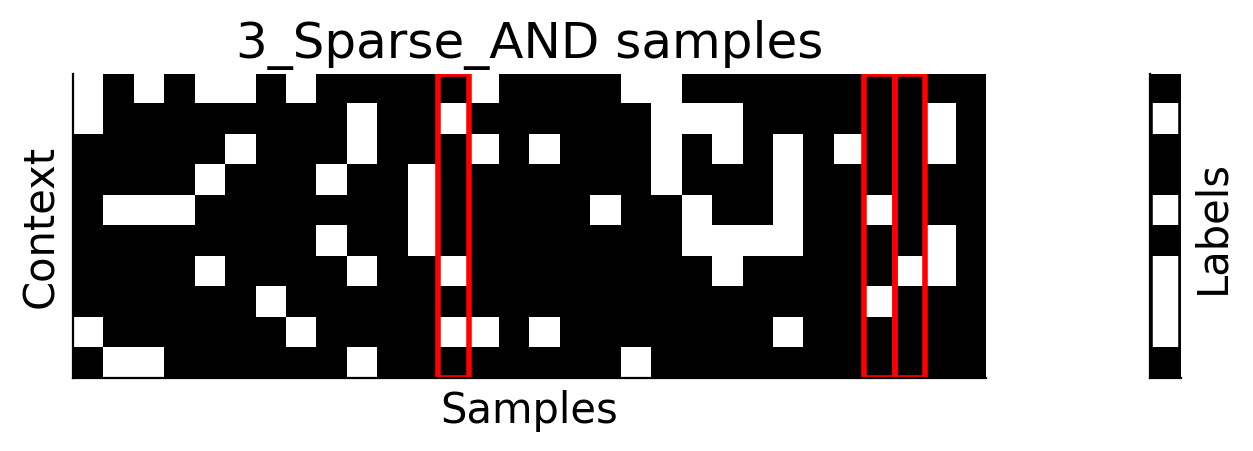

In [15]:
context_length = 30  # T: context length
s_sparse = 3  # s: sparsity (number of function-relevant indices)
n_sequences = 10  # m: number of samples (sequences)
data_gen = s_Sparse_AND(context_length, s_sparse)
X_, y_ = data_gen.generate(n_sequences, verbose=False)
correct_ids = data_gen.f_i
print(f"Target (function-relevant indices) indices: {correct_ids}")

plot_samples(X_, y_, correct_ids, f"{s_sparse}_Sparse_AND samples")

## Exercise 2. MLP vs. Self-Attention

Let's put the MLP and Self-Attention to the test, and see which of the two architectures can generalize better in this problem. We will test both on sparse function (*s* = 3) as well as a denser function (*s* = 15) for the context length of *T* = 30. We will be using a helper-function `make_train` that takes the model and hyper-parameters and will return the trained model and some results.

This exercise has 4 parts:

1. Create training and validation datasets for MLP, and train an MLP model on the task
2. Repeat for the self-attention model
3. Plot to compare the results for the two models and datasets
4. You finally can change the sample complexity of the MLP dataset, to get to 100% accuracy.
5. Plot the attention score (attention weights) for the transformer!

**ABBREVIATIONS:**
- suffix `_s` = sparse
- suffix `_d` = dense
- prefix `t_` = training
- prefix `v_` = validation
- `model_np` = number of parameters
- `sat` = Self-Attention Transformer

In [16]:
# Problem hyperparameters
context_length = 30  # T: context length
sparse_dense = [3, 10]  # s: sparsity (number of function-relevant indices)
B_valid = 500  # batch size for validation


### Part 1: MLP
Training an MLP on the "s-Sparse AND" task. How does the model do?

In [17]:
# # Hyperparameters for sparse MLP
B_t_mlp = 50  # batch size for training (number of training samples)
n_epochs = 500  # number of epochs
s_sparse = sparse_dense[0]  # sparse
hidden_layers = [512]  # the number of hidden units in each layer [H1, H2, ...]
kind = "MLP"

mlp_model = BinaryMLP(context_length, hidden_layers, 1)  # MLP model
results_mlp_s = make_train(mlp_model, context_length, s_sparse, B_t_mlp, B_valid, n_epochs, DEVICE, kind)

Number of model's learnable parameters: 16385
Training loss: 0.003, accuracy: 1.000
Validation loss: 0.626, accuracy: 0.870


In [18]:
# # Hyperparameters for dense MLP
B_t_mlp = 50  # batch size for training (number of training samples)
n_epochs = 500  # number of epochs
s_sparse = sparse_dense[1]  # dense
hidden_layers = [512]  # the number of hidden units in each layer [H1, H2, ...]
kind = "MLP"

mlp_model = BinaryMLP(context_length, hidden_layers, 1)  # MLP model
results_mlp_d = make_train(mlp_model, context_length, s_sparse, B_t_mlp, B_valid, n_epochs, DEVICE, kind)

Number of model's learnable parameters: 16385
Training loss: 0.030, accuracy: 0.980
Validation loss: 0.502, accuracy: 0.822


### Part 2. Self-Attention

Build a Transformer model and train it on the given dataset. How does the training results compare to MLP?

In [19]:
# # Hyperparameters for sparse SAT
B_t_sat = 50  # batch size for training (number of training samples)
n_epochs = 500  # number of epochs
s_sparse = sparse_dense[0]  # sparse
embed_dim = 32  # embedding dimension
n_heads = 1  # number of heads
hidden_dim = 64  # number of hidden units
kind = "SAT"

sat_model_s = BinarySAT(context_length, embed_dim, n_heads, hidden_dim)  # selt-attention transformer
results_sat_s = make_train(sat_model_s, context_length, s_sparse, B_t_sat, B_valid, n_epochs, DEVICE, kind)


Number of model's learnable parameters: 9729
Training loss: 0.002, accuracy: 1.000
Validation loss: 0.002, accuracy: 1.000


In [20]:
# # Hyperparameters for dense SAT
B_t_sat = 50  # batch size for training (number of training samples)
n_epochs = 500  # number of epochs
s_sparse = sparse_dense[1]  # dense
embed_dim = 32  # embedding dimension
n_heads = 1  # number of heads
hidden_dim = 64  # number of hidden units
kind = "SAT"

sat_model_d = BinarySAT(context_length, embed_dim, n_heads, hidden_dim)  # selt-attention transformer
results_sat_d = make_train(sat_model_d, context_length, s_sparse, B_t_sat, B_valid, n_epochs, DEVICE, kind)

Number of model's learnable parameters: 9729
Training loss: 0.002, accuracy: 1.000
Validation loss: 0.617, accuracy: 0.904


### Part 3. Coding Exercise Comparing results

Here, we ask you to plot the results of the trainings above and the hyper-parameters you think are important. The goal is to show in one plot how Self-Attention Transformers and Multi-Layer Perceptons compare for both sparse and dense boolean tasks. You can use any or all of the following information in your plot:
- number of parameters
- training samples
- validation accuracy
- validation loss

We have provided the results in an ordered dictionary `ordered_results` for your convenience.

**Hint:** You can maximise creativity and information-communication :)

In [21]:
# Validation loss, accuracy, number of parameters and number of training samples
ordered_results = results_dict(results_sat_d, results_sat_s, results_mlp_d, results_mlp_s)
ordered_results

OrderedDict([('Validation Loss SAT dense', 0.617),
             ('Validation Accuracy SAT dense', 0.904),
             ('Number of Parameters SAT dense', 9729),
             ('Validation Loss SAT sparse', 0.002),
             ('Validation Accuracy SAT sparse', 1.0),
             ('Number of Parameters SAT sparse', 9729),
             ('Validation Loss MLP dense', 0.502),
             ('Validation Accuracy MLP dense', 0.822),
             ('Number of Parameters MLP dense', 16385),
             ('Validation Loss MLP sparse', 0.626),
             ('Validation Accuracy MLP sparse', 0.87),
             ('Number of Parameters MLP sparse', 16385)])

### Part 4. Sample complexity
One measure of generalization is sample complexity. You can change the number of training samples to check if MLP can do better. Also, only train the MLP model and avoid retraining the transformer to save energy and time

### Part 5. Attention Weights

A common figure in attention literature is the "Attention visualization" which shows how the model is attending to different parts of the sequence. You have already implemented the function that returns the attention weight $\mathbf{w}$, and we will use a similar implementation for our transformer model. The blue rectangles show the target (function-relevant indices) indices. You can see for the `True` sequences (where the target label is `True`), the attention weight would push all the irrelevant values down and increase the attention to the target indices.

Target (function-relevant indices) indices: [3, 14, 21]


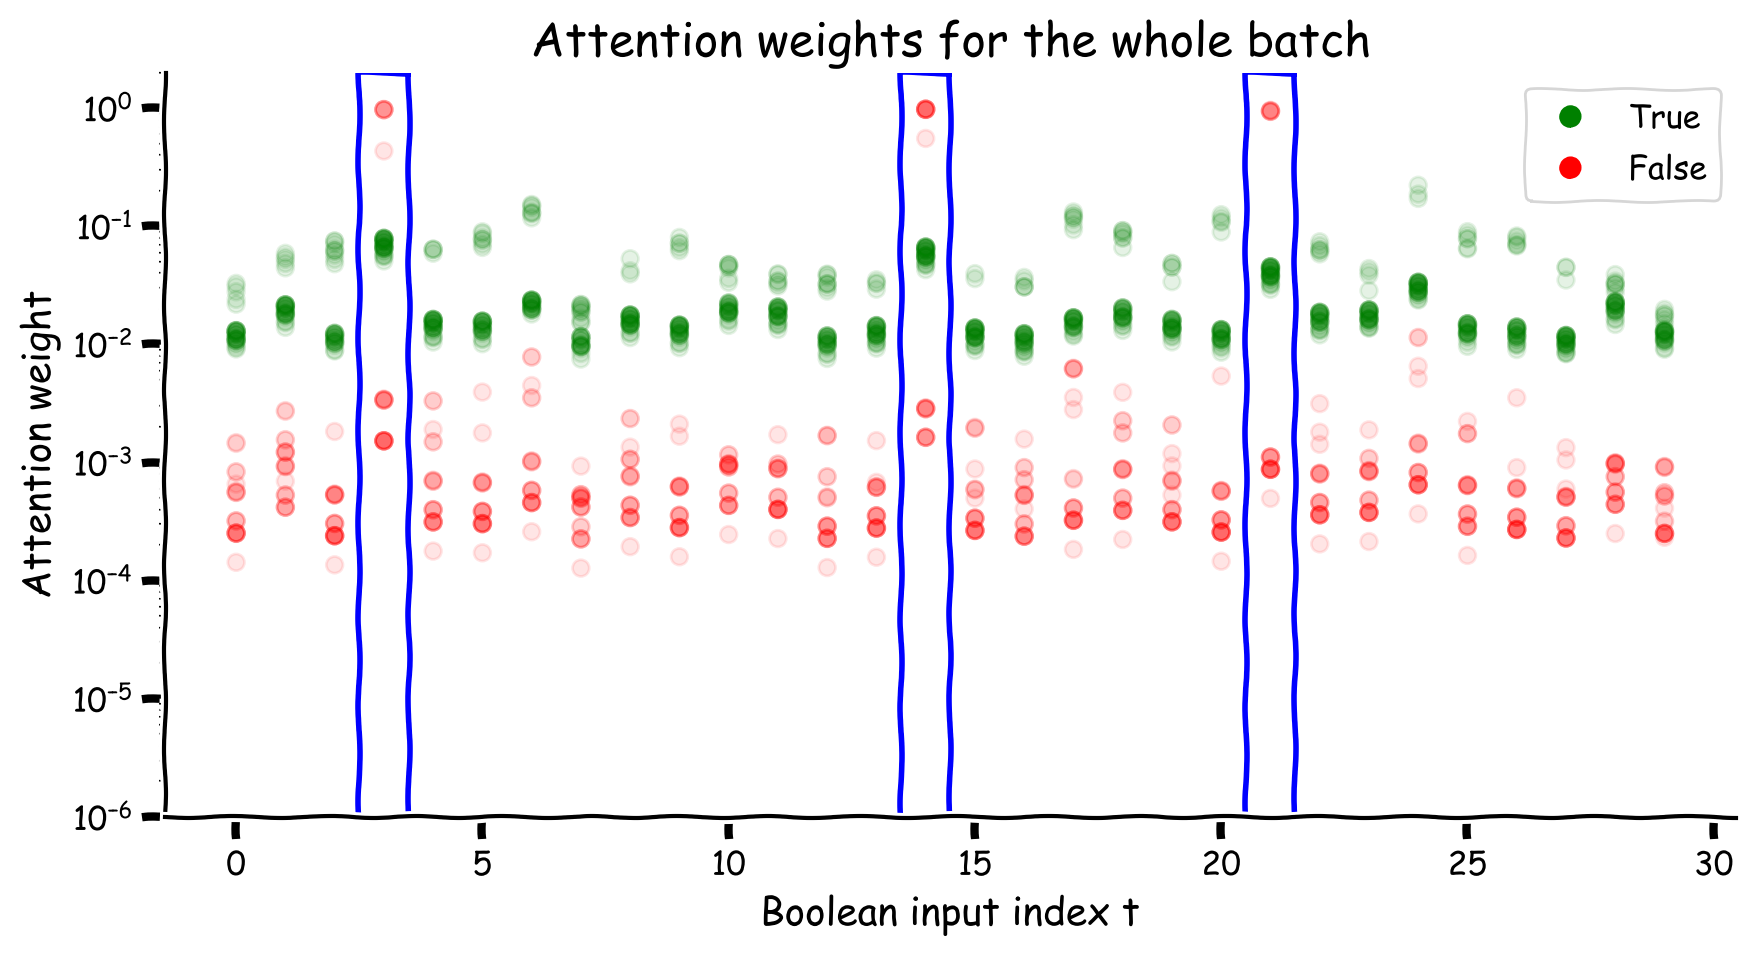

In [25]:
# # Hyperparameters for sparse SAT
context_length = 30  # T: context length
B_t_sat = 50  # batch size for training (number of training samples)
n_epochs = 500  # number of epochs
s_sparse = 3  # sparse
embed_dim = 32  # embedding dimension
n_heads = 1  # number of heads
hidden_dim = 64  # number of hidden units
n_sequences = 50  # number of samples for ploting
kind = "SAT"

sat_model_s = BinarySAT(context_length, embed_dim, n_heads, hidden_dim)  # selt-attention transformer
data_gen = make_train(sat_model_s, context_length, s_sparse, B_t_sat, B_valid, n_epochs, DEVICE, kind, False)
X_, y_ = data_gen.generate(n_sequences, verbose=False)
correct_ids = data_gen.f_i
print(f"Target (function-relevant indices) indices: {correct_ids}")
with torch.no_grad():
    w_att = weighted_attention(sat_model_s, X_.to(DEVICE)).cpu().detach()
with plt.xkcd():
    plot_attention_weights(w_att, correct_ids, context_length, y_)

## Sample Complexity for sparse variable creation

So far, we saw that a simple transformer model can effectively learn to represent an s-sparse boolean function. Next, we would like to quantify the sample complexity of self-attention for these functions. The Figure below is from the paper [Inductive Biases and Variable Creation in Self-Attention Mechanisms](https://proceedings.mlr.press/v162/edelman22a.html). Given the time and computation limits of our tutorial, we will only show their results here, but you can find the implementation and detailed results on GitHub.

They rigorously show that the number of training samples $m$ needed to achieve good performance on an s-sparse function (the 'critical sample size') grows only *logarithmically* with context length $T$.

<div>
<img src="https://raw.githubusercontent.com/ssnio/nma_neuroai_d4_t4/main/static/Fig_2_ref2.png" width="500"/>
</div>